# Data Cleaning

### Sources: [Automating GIS-processes 2021](https://autogis-site.readthedocs.io/en/latest/lessons/L4/overview.html) and [leafmap](https://leafmap.org/notebooks/26_kepler_gl/)

### Data available [here](https://github.com/dahlalex/website/tree/main/notebooks)

### The goal is to create boundaries of Finnish hospital districts.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
%matplotlib inline

## 1- Get and fix the data for municipalities 

In [2]:
# Municipality polygons (wfs)

url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON"
geodata = gpd.read_file(url)

In [3]:
geodata.head()

,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta1000k.1,005,2022,Alajärvi,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,kunta1000k.2,009,2022,Alavieska,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,kunta1000k.3,010,2022,Alavus,Alavo,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,kunta1000k.4,016,2022,Asikkala,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,kunta1000k.5,018,2022,Askola,Askola,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


In [4]:
geodata.shape # there are 310 municipalities in Finland in 2020. The municipality of (Åland) is missing here.

(309, 7)

In [5]:
#Select and rename columns
geodata.rename(columns={"kunta": "code"}, inplace=True)

geodata = geodata[["code", "name", "geometry"]]

geodata.head()


,code,name,geometry
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,018,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


<AxesSubplot:>

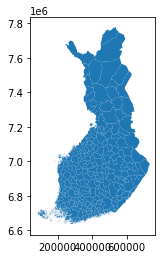

In [6]:
geodata.plot()

## 2- Get and fix the data for the health care districts

In [7]:
# Read in the excel spreadsheet. The excel package should be installed (conda install -c conda-forge xlrd).
# the header is located on the 4th row (index 3) of the excel spreadsheet.

data = pd.read_excel(r"data/Shp_jäsenkunnat_2020.xls", sheet_name="kunnat_shp_2020_ aakkosjärj.", header=3)

In [8]:
data.head()

,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
0,NaN,NaN,NaN,NaN,NaN,NaN
1,20.0,Akaa,6.0,Pirkanmaa,TAYS,1.0
2,5.0,Alajärvi,15.0,Etelä-Pohjanmaa,TAYS,2.0
3,9.0,Alavieska,18.0,Pohjois-Pohjanmaa,OYS,3.0
4,10.0,Alavus,15.0,Etelä-Pohjanmaa,TAYS,4.0


In [9]:
data.shape

(295, 6)

In [10]:
# the first row after the header is empty. We can get rid of it using the dropna() -function:
data = data.dropna()

In [11]:
data.shape

(294, 6)

In [12]:
# Rename and select

data.rename(columns={"kunta-\nkoodi":"code", "sairaanhoitopiiri":"healthCareDistrict"}, inplace= True)
data= data[["code", "healthCareDistrict"]]

In [13]:
data.head()

,code,healthCareDistrict
1,20.0,Pirkanmaa
2,5.0,Etelä-Pohjanmaa
3,9.0,Pohjois-Pohjanmaa
4,10.0,Etelä-Pohjanmaa
5,16.0,Päijät-Häme


## 3- Combine the data of municipalities and the health care districts.

In [14]:
# Check data type
print(geodata.dtypes)


code          object
name          object
geometry    geometry
dtype: object


In [15]:
print(data.dtypes)


code                  float64
healthCareDistrict     object
dtype: object


In [16]:
# The code column is currently a floating point number. We need to modify these codes so that they match the ones in the spatial data:

# Convert to character string
data["code"] = data["code"].astype(int).astype("str")



In [17]:
# Add missing zeros to municipality codes
data["code"] = data["code"].str.zfill(3)


In [18]:
#  The 16 municipalities of Åland Region are missing from the the health care districts file.
#  The municipality of (Åland) is missing from the municipalities file.

print(data.shape)
print(geodata.shape)

(294, 2)
(309, 3)


In [19]:
# Merge health district info to geodata using "code" as the common key and "how" to keep all the municipalties

geodata = geodata.merge(data, on="code", how= "left")

In [20]:
geodata.head()

,code,name,geometry,healthCareDistrict
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6...",Etelä-Pohjanmaa
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7...",Pohjois-Pohjanmaa
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6...",Etelä-Pohjanmaa
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6...",Päijät-Häme
4,018,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6...",HUS


In [21]:
# List all municipalities that lack health district info:
geodata[geodata["healthCareDistrict"].isnull()].name

7          Brändö
8          Eckerö
15       Finström
17          Föglö
18           Geta
24     Hammarland
57         Jomala
111      Kumlinge
121         Kökar
134       Lemland
147    Lumparland
153     Mariehamn
236       Saltvik
254      Sottunga
256          Sund
301         Vårdö
Name: name, dtype: object

In [22]:
# Update "Ahvenanmaa" as the health care district for Åland municipalities (16 municipalities in total)

# The format of "loc" comand is loc["what rows do I want"  , "what columns do i want" ]

geodata.loc[geodata["healthCareDistrict"].isnull(), "healthCareDistrict"] = "Ahvenanmaa"

In [23]:
# Check the count of municipalities per health care disctrict
geodata["healthCareDistrict"].value_counts()

Pohjois-Pohjanmaa    29
Varsinais-Suomi      28
HUS                  24
Pirkanmaa            23
Keski-Suomi          21
Etelä-Pohjanmaa      18
Pohjois-Savo         18
Ahvenanmaa           16
Satakunta            16
Lappi                15
Vaasa                13
Pohjois-Karjala      13
Päijät-Häme          12
Kanta-Häme           11
Keski-Pohjanmaa      10
Etelä-Savo            9
Etelä-Karjala         9
Kainuu                8
Kymenlaakso           6
Länsi-Pohja           6
Itä-Savo              4
Name: healthCareDistrict, dtype: int64

In [24]:
# Dissolve (=combine) municipality polygon geometries for each health care district
districts = geodata.dissolve(by='healthCareDistrict')

In [25]:
districts.head()

,geometry,code,name
healthCareDistrict,,,
Ahvenanmaa,"MULTIPOLYGON (((160681.339 6644663.142, 160710...",035,Brändö
Etelä-Karjala,"POLYGON ((592557.900 6768951.300, 592411.200 6...",153,Imatra
Etelä-Pohjanmaa,"POLYGON ((222946.328 6887833.806, 220077.099 6...",005,Alajärvi
Etelä-Savo,"POLYGON ((520632.817 6786551.176, 520842.240 6...",097,Hirvensalmi
HUS,"MULTIPOLYGON (((272126.112 6633609.689, 272356...",018,Askola


In [26]:
# reset the index
districts.reset_index(inplace=True)

# Select useful columns
districts = districts[["healthCareDistrict", "geometry"]]

In [27]:
districts.head()

,healthCareDistrict,geometry
0,Ahvenanmaa,"MULTIPOLYGON (((160681.339 6644663.142, 160710..."
1,Etelä-Karjala,"POLYGON ((592557.900 6768951.300, 592411.200 6..."
2,Etelä-Pohjanmaa,"POLYGON ((222946.328 6887833.806, 220077.099 6..."
3,Etelä-Savo,"POLYGON ((520632.817 6786551.176, 520842.240 6..."
4,HUS,"MULTIPOLYGON (((272126.112 6633609.689, 272356..."


In [28]:
districts.shape

(21, 2)

## 4- Plot the data

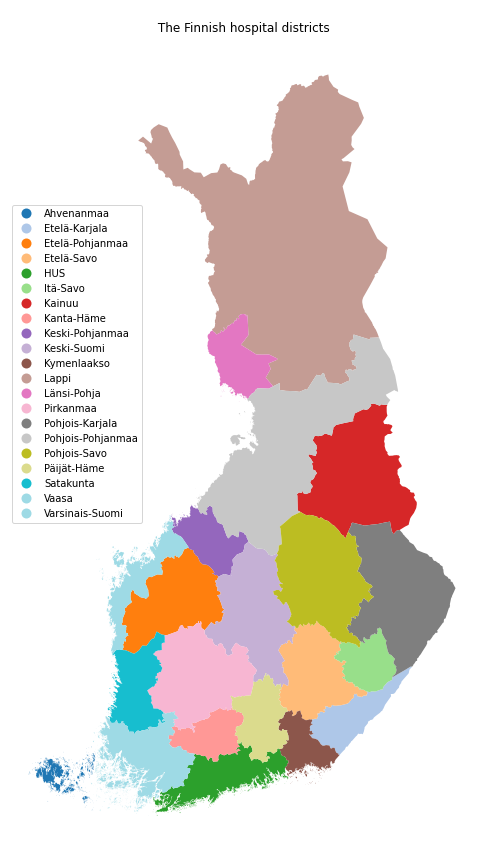

In [29]:
fig, ax = plt.subplots(figsize= (12, 15))
districts.plot(ax=ax, column="healthCareDistrict", cmap='tab20' , legend= True,
             legend_kwds={'loc': 'center left',
                         'bbox_to_anchor':(0,0.6)})
ax.set(title= "\n The Finnish hospital districts")
ax.axis('off')
#plt.savefig("static_maps/finnish_hospital_districts.png", dpi= 300, facecolor= "white" )
plt.show()

In [30]:
districts.crs

<Derived Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [31]:
# Write GeoJSON in original projection
districts.to_file(f"data/healthDistrictsEPSG3067.geojson", driver='GeoJSON', encoding='utf-8')

C:\Users\dahla\miniconda3\envs\autogis2021\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [32]:
# Re-project to WGS84 and save again

districts.to_crs(epsg=4326).to_file("data/healthDistrictsEPSG4326.geojson", driver='GeoJSON', encoding='utf-8')

C:\Users\dahla\miniconda3\envs\autogis2021\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## 4- Create an interactive map

In [33]:
import leafmap.kepler as leafmap

In [34]:
m = leafmap.Map(center=[65.32, 24.8], zoom=4)

In [35]:

fp = r"data/healthDistrictsEPSG4326.geojson" 

m.add_geojson(fp, layer_name="The Finnish hospital districts")
             
 

In [36]:
m

Map(config={'version': 'v1', 'config': {'mapState': {'latitude': 65.32, 'longitude': 24.8, 'zoom': 4, 'bearing…

In [37]:
m.to_html("interactive_maps/Finnish_hospital_districts.html")